In [46]:
# this produces the charts for the paper
import matplotlib as mpl

# for saving charts as .tiff
from io import BytesIO
from PIL import Image

'''
mpl.use("pgf")
pgf_with_custom_preamble = {
    "pgf.rcfonts": False   # don't setup fonts from rc parameters
}
mpl.rcParams.update(pgf_with_custom_preamble)
'''

import matplotlib.pyplot as plt
import numpy as np
#import xelatex
from sklearn.metrics import roc_curve, auc
from scipy import interp
import sklearn
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle


data_root_folder = 'data'
data_raw_folder = data_root_folder + '/raw'
data_processed_folder = data_root_folder + '/processed'
data_cached_folder= data_root_folder + '/cached'
datasets_folder = data_root_folder + '/datasets'
results_folder='data/results/seen_diseases/'

dataset='test' # dev or test
number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0


models=['cnn_flat','bilstm','cnn_funnel','cnn_hierarchical','uth_ccb']

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: 'Never diagnosed',
    1: 'Pre-diagnostic window',
    2: 'Post-diagnostic window',
    3: 'Inter-diagnostic window'}

'''

1. a chart of 4 class curves for each classifier.  This shows that CNN gets its perf increase from the two rarer classes
2. a plot of CNN vs UTH, micro-average and macro-average
3. a count of classes, from a combination of train/dev/test y results
'''


'\n\n1. a chart of 4 class curves for each classifier.  This shows that CNN gets its perf increase from the two rarer classes\n2. a plot of CNN vs UTH, micro-average and macro-average\n3. a count of classes, from a combination of train/dev/test y results\n'

In [2]:
# saves charts as .tiff format
def save_chart(file_name_without_extension):
    # save figure as tiff
    
    
    # (1) save the image in memory in PNG format
    png1 = BytesIO()
    plt.savefig(png1, format='png')

    # (2) load this image into PIL
    png2 = Image.open(png1)

    # (3) save as TIFF
    png2.save('%s.tiff' % file_name_without_extension)
    png1.close()
    
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    

In [3]:
# chart parameters

figsize=cm2inch(8.6,8.6) # controls how large the charts are, numbers chosen according to nature's 86mm single column recommendation
legend_fontsize=7.5
dpi=300

#these stop the titles from being squashed off the side of the image
bottom_margin=0.15
left_margin=0.2

Calculates the class prevalences

In [4]:
def load_dataset(experiment=8,dataset='train'):
    y=np.load(datasets_folder+'/y_%s_exp_%s_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,experiment,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    return y

def load_all_datasets(experiment):
    datasets=['train','test','dev']
    counts={}

    for dataset in datasets:
        y=load_dataset(experiment,dataset)
        print('total number sentences for %s = %s'%(dataset,y.shape[0]))
        dataset_counts=sum(y)
        for i in range(0,number_of_classes):
            counts[i]=counts.get(i,0)+dataset_counts[i]
    return counts
# 8=referral
# 9=primary

counts_referral=load_all_datasets(8)
counts_primary=load_all_datasets(9)


total number sentences for train = 448486
total number sentences for test = 56138
total number sentences for dev = 56183
total number sentences for train = 72242
total number sentences for test = 8996
total number sentences for dev = 9104


In [5]:
total_primary=sum(counts_primary.values())
total_referral=sum(counts_referral.values())

# counts
print('primary\t\treferral\tlabel')
for i in range(0,number_of_classes):
    print('%s\t\t%s\t\t%s' %(counts_primary[i],counts_referral[i],class_labels[i]))

print("%s\t\t%s\t\tTotal" %(total_primary,total_referral))
print()

# totals counts
print('count\t\tlabel')
for i in range(0,number_of_classes):
    print('{0} ({1:0.4f})\t\t{2}'.format(
        counts_primary[i]+counts_referral[i]
        ,(counts_primary[i]+counts_referral[i])/(total_primary+total_referral) 
        ,class_labels[i]))
print()

# percentages
print('primary\t\treferral\tlabel')
for i in range(0,number_of_classes):
    print("{0:0.4f}\t\t{1:0.4f}\t\t{2}".format(
        counts_primary[i]/total_primary,counts_referral[i]/total_referral,class_labels[i]
    ))
          
print()
print('total num sentences=%s' % (total_primary+total_referral))

primary		referral	label
46018		195763		Never diagnosed
8869		13988		Pre-diagnostic window
35254		347994		Post-diagnostic window
201		3062		Inter-diagnostic window
90342		560807		Total

count		label
241781 (0.3713)		Never diagnosed
22857 (0.0351)		Pre-diagnostic window
383248 (0.5886)		Post-diagnostic window
3263 (0.0050)		Inter-diagnostic window

primary		referral	label
0.5094		0.3491		Never diagnosed
0.0982		0.0249		Pre-diagnostic window
0.3902		0.6205		Post-diagnostic window
0.0022		0.0055		Inter-diagnostic window

total num sentences=651149


In [6]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle

def evaluate(y_true, y_pred, plot=True, title='Receiver operating characteristic'):
    
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=list()
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
            
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    if(len(drop_classes)!=0):
        print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot:
        # Plot all ROC curves
        plt.figure()
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='{0} area={1:0.2f}'
                     ''.format(class_labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc

#class_labels = dict of ordinal -> label
#classifier='CNN' or 'UTH-CCB'
def evaluate(y_true, y_pred, class_labels, classifier):


    
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds={}
    for i in range(num_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds['micro'] = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot 4 class ROC Curves
    plt.figure(figsize=figsize,dpi=dpi)
    plt.tight_layout()
    lw = 1

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i], 
            tpr[i], 
            color=color, 
            lw=lw,
            label='{0} (AUC={1:0.2f}'.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    #plt.title('%s - Per class ROC curves' % classifier)
    plt.legend(loc="lower right",fontsize=legend_fontsize)
    plt.subplots_adjust(bottom=bottom_margin,left=left_margin)
    save_chart('data/results/final_paper_1.0/%s_test_4_class_ROC' % classifier)
    
    #plt.savefig('data/results/final_paper_1.0/%s_test_4_class_ROC.pdf'% classifier) 
    #plt.savefig('data/results/final_paper_1.0/%s_test_4_class_ROC.pgf'% classifier)
    '''
    # these charts cause an error when saving and they arent currently in the paper
    average_precision = average_precision_score(y_true,y_pred)
    print('label_ranking_average_precision_score:%s' % label_ranking_average_precision_score(y_true,y_pred))
    print('average_precision_score:%s' % average_precision)
    
    # now P/R curve
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

    plt.xlabel('Recall (sensitivity)')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('%s - Micro-average Precision-Recall curve: AP={0:0.2f}'.format(average_precision, classifier))
    plt.close('all')
    # saving these files produces a latex error
    #plt.savefig('data/results/final_paper_1.0/%s_test_precision-recall-curve.pdf' % classifier) 
    #plt.savefig('data/results/final_paper_1.0/%s_test_precision.pgf'% classifier)
    '''
    # how to find best threshold
    #https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    optimal_threshold={}
    for i in range(0,4):
        optimal_idx = np.argmax(tpr[i] - fpr[i])
        optimal_threshold[i] = thresholds[i][optimal_idx]
    return fpr,tpr,roc_auc,optimal_threshold

# all parameteres are teh fpr/tpr dicts produced by calls to evaluate()
def plot_average_rocs(fpr_cnn,tpr_cnn,roc_auc_cnn,fpr_uth,tpr_uth, roc_auc_uth):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.tight_layout()
    lw = 2
    # micro
    plt.plot(
        fpr_cnn["micro"], 
        tpr_cnn["micro"],
        label='CNN Micro-average (AUC={0:0.2f})'.format(roc_auc_cnn["micro"]),
        color='navy', 
        linewidth=1)
    plt.plot(
        fpr_uth["micro"], 
        tpr_uth["micro"],
        label='UTH-CCB Micro-average (AUC={0:0.2f})'.format(roc_auc_uth["micro"]),
        color='navy', 
        linestyle=':', 
        linewidth=1)
    # macro
    plt.plot(
        fpr_cnn["macro"], 
        tpr_cnn["macro"],
        label='CNN Macro-average (AUC={0:0.2f})'.format(roc_auc_cnn["macro"]),
        color='deeppink', 
        linewidth=1)
    plt.plot(
        fpr_uth["macro"], 
        tpr_uth["macro"],
        label='UTH-CCB Macro-average (AUC={0:0.2f})'.format(roc_auc_uth["macro"]),
        color='deeppink', 
        linestyle=':', 
        linewidth=1)
   
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    # plt.title('CNN vs UTH-CCB - average ROC curves',fontsize=8) # title looks a bit funny in the doc
    plt.legend(loc="lower right",fontsize=legend_fontsize)
    plt.subplots_adjust(bottom=bottom_margin,left=left_margin)
    
    save_chart('data/results/final_paper_1.0/Figure 1')
    #plt.savefig('data/results/final_paper_1.0/test_average_ROC.pdf') 
    #plt.savefig('data/results/final_paper_1.0/test_average_ROC.pgf') 
    plt.close('all')
    


# this method searches for the threshold which maximises the F1 score for each class
def find_threshold(granularity=41,lower_bound=0,upper_bound=1,classifier='cnn'):
    optimal_class_thresholds={}
    print('finding best thresholds for classifier %s' % classifier)
    for class_id in range(0,4):
        best_score=0,0
        for threshold in np.linspace(lower_bound,upper_bound,granularity):
            y_pred_actual=y_pred[classifier]
            rows,_=y_pred_actual.shape
            y_pred_thresholds=np.copy(y_pred_actual[:,class_id])

            for row in range(0,rows):
                if y_pred_actual[row,class_id]<=threshold:
                    y_pred_thresholds[row]=0
                else:
                    y_pred_thresholds[row]=1
            f1=sklearn.metrics.f1_score(y_true[classifier][:,class_id],y_pred_thresholds)
            if f1>best_score[1]:
                best_score=threshold,f1
        print('best threshold for class ''%s'' is %s (f1=%s)' %(class_labels[class_id],best_score[0],best_score[1]))
        optimal_class_thresholds[class_id]=best_score[0]
    return optimal_class_thresholds





***
seen-diseases
***
finding best thresholds for model_name cnn_flat


/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best threshold for class Never diagnosed is 0.35000000000000003 (f1=0.7168702589123545)
best threshold for class Pre-diagnostic window is 0.2 (f1=0.28880157170923376)
best threshold for class Post-diagnostic window is 0.4 (f1=0.819310637595368)
best threshold for class Inter-diagnostic window is 0.275 (f1=0.36000000000000004)
finding best thresholds for model_name bilstm
best threshold for class Never diagnosed is 0.4 (f1=0.755436537329307)
best threshold for class Pre-diagnostic window is 0.2 (f1=0.3414517669531996)
best threshold for class Post-diagnostic window is 0.4 (f1=0.8439822057098162)
best threshold for class Inter-diagnostic window is 0.15000000000000002 (f1=0.43267776096822996)
finding best thresholds for model_name cnn_funnel
best threshold for class Never diagnosed is 0.35000000000000003 (f1=0.7378275037200278)
best threshold for class Pre-diagnostic window is 0.25 (f1=0.316032887975334)
best threshold for class Post-diagnostic window is 0.42500000000000004 (f1=0.83330492

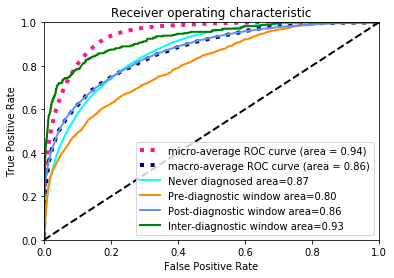

{0: 0.8653694807271725, 1: 0.7996380235407665, 2: 0.8636451168197824, 3: 0.9251761953646307, 'micro': 0.9438848328950475, 'macro': 0.8634582830547891}
bilstm


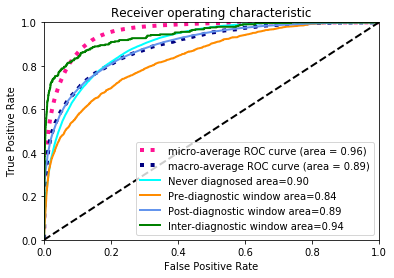

{0: 0.8979262109367653, 1: 0.8376706255240642, 2: 0.8938772418976295, 3: 0.9432244649080931, 'micro': 0.955351296440582, 'macro': 0.8931758447289443}
cnn_funnel


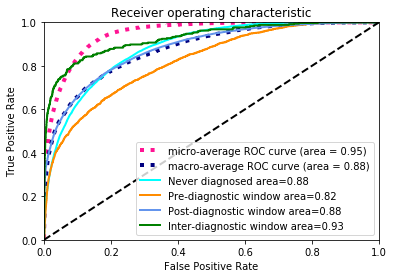

{0: 0.8830712608326658, 1: 0.8230364304772382, 2: 0.8809099241162417, 3: 0.9274036287181844, 'micro': 0.9504337716078395, 'macro': 0.8786146000235515}
cnn_hierarchical


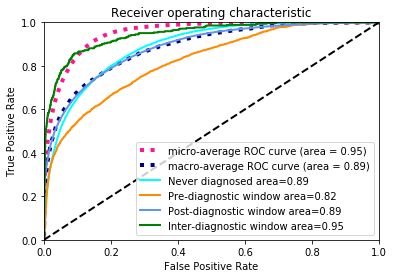

{0: 0.8899167390520005, 1: 0.8225496654706641, 2: 0.8857716717700416, 3: 0.9457536782520989, 'micro': 0.952399152933344, 'macro': 0.8859991062531831}
uth_ccb


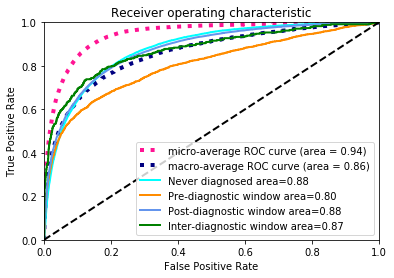

{0: 0.8780870253386573, 1: 0.8033825745754672, 2: 0.8755333384086004, 3: 0.8722100157216337, 'micro': 0.9442352366445151, 'macro': 0.8573150774872458}
***

unseen-diseases
***
precision micro
{'cnn_hierarchical': 0.6113441610069897, 'cnn_funnel': 0.5862169506395464, 'uth_ccb': 0.6010408095939122, 'bilstm': 0.6251377987248703, 'cnn_flat': 0.5810734069519518}
recall micro
{'cnn_hierarchical': 0.7795931465089049, 'cnn_funnel': 0.7618603015727253, 'uth_ccb': 0.7867723115682532, 'bilstm': 0.7733783723812092, 'cnn_flat': 0.7684710733927103}
f1 micro scores
{'cnn_hierarchical': 0.685292882006962, 'cnn_funnel': 0.6625961858912267, 'uth_ccb': 0.6814783055445699, 'bilstm': 0.6914014485931038, 'cnn_flat': 0.6617612257526828}

precision macro
{'cnn_hierarchical': 0.4299352683919063, 'cnn_funnel': 0.4790053944167565, 'uth_ccb': 0.440473558471536, 'bilstm': 0.45436244607475396, 'cnn_flat': 0.44138681264064106}
recall macro
{'cnn_hierarchical': 0.4497486611414437, 'cnn_funnel': 0.391356556422553, 'ut

/home/noel/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


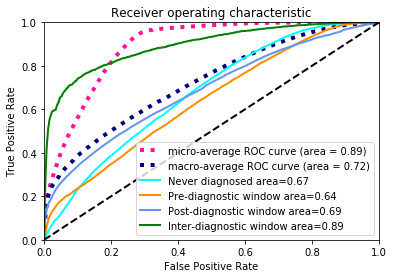

{0: 0.6747467641140279, 1: 0.6393226770908635, 2: 0.6854035290518087, 3: 0.8938201637989502, 'micro': 0.8915271285801973, 'macro': 0.7233233072342963}
bilstm


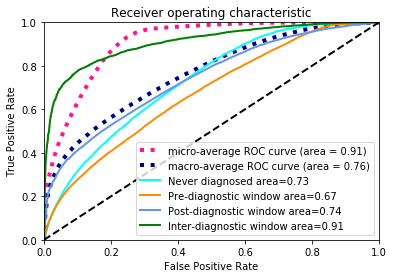

{0: 0.7304026725712804, 1: 0.6748915659170581, 2: 0.7413228863217882, 3: 0.9077133173702476, 'micro': 0.9081009861084988, 'macro': 0.763582641349192}
cnn_funnel


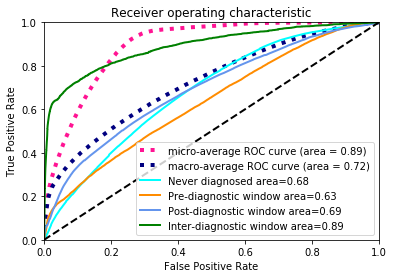

{0: 0.680482235620476, 1: 0.6332048493644489, 2: 0.6914233454412689, 3: 0.8894615034096276, 'micro': 0.8936691996149227, 'macro': 0.7236430126921425}
cnn_hierarchical


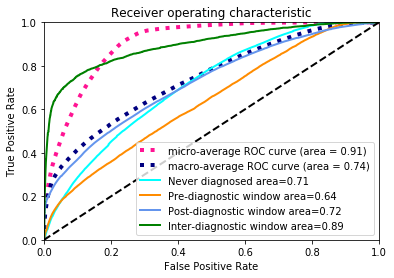

{0: 0.712324879968093, 1: 0.6366517006906895, 2: 0.7220715244665912, 3: 0.8946450072307712, 'micro': 0.9060985601443112, 'macro': 0.741423325733434}
uth_ccb


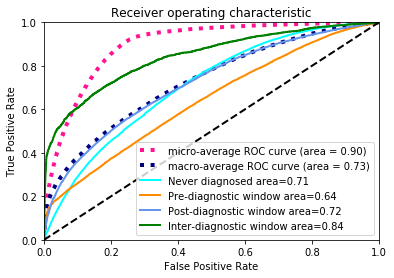

{0: 0.7092046874625891, 1: 0.6390657763833676, 2: 0.7187655879571948, 3: 0.8421290884304424, 'micro': 0.8973224333717982, 'macro': 0.7272924306436641}
***


In [27]:
def print_tables_for_paper(file_template, optimal_threshold=None):
    
    
    # loads the pre-run predictions and true labels
    def load_model_results(dataset='dev'):
        y_pred={model:np.load(file_template % ('pred',dataset,model)) for model in models}
        y_true={model:np.load(file_template % ('true',dataset,model)) for model in models}
        return y_pred,y_true
    
    # this method searches for the threshold which maximises the F1 score for each class
    def find_threshold(granularity=41,lower_bound=0,upper_bound=1,model_name='cnn',y_pred=None,y_true=None):
        optimal_class_thresholds={}
        print('finding best thresholds for model_name %s' % model_name)
        for class_id in range(0,4):
            best_score=0,0
            for threshold in np.linspace(lower_bound,upper_bound,granularity):
                y_pred_actual=y_pred[model_name]
                rows,_=y_pred_actual.shape
                y_pred_thresholds=np.copy(y_pred_actual[:,class_id])

                for row in range(0,rows):
                    if y_pred_actual[row,class_id]<=threshold:
                        y_pred_thresholds[row]=0
                    else:
                        y_pred_thresholds[row]=1
                f1=sklearn.metrics.f1_score(y_true[model_name][:,class_id],y_pred_thresholds)
                if f1>best_score[1]:
                    best_score=threshold,f1
            print('best threshold for class ''%s'' is %s (f1=%s)' %(class_labels[class_id],best_score[0],best_score[1]))
            optimal_class_thresholds[class_id]=best_score[0]
        return optimal_class_thresholds
    
    
    
    if optimal_threshold==None:
        # first we load dev, and find the best decision thresholds for each class
        y_pred_dev,y_true_dev=load_model_results(dataset='dev')

        # thresholds for neural models are between 0 and 1
        optimal_threshold={model:find_threshold(41,0,1, model,y_pred_dev,y_true_dev) for model in models if model != 'uth_ccb'}

        # thresholds for SVM is -1 to 1
        optimal_threshold['uth_ccb']=find_threshold(41,-1,1,'uth_ccb',y_pred_dev,y_true_dev,)
    

    f1_micro,f1_macro,precision,precision_micro,precision_macro,recall,recall_micro,recall_macro={},{},{},{},{},{},{},{}

    y_pred_test,y_true_test=load_model_results(dataset='test')
    
    def apply_thresholds(thresholds, y_pred):
        y_pred_thresholds=np.copy(y_pred)
        rows,columns=y_pred.shape

        for i in range(0,rows):
            for j in range(0,columns):
                if y_pred[i,j]<=thresholds[j]:
                    y_pred_thresholds[i,j]=0
                else:
                    y_pred_thresholds[i,j]=1

        return y_pred_thresholds

    for classifier in models:
        y_true_classifier=y_true_test[classifier]
        y_pred_classifier=apply_thresholds(optimal_threshold[classifier],y_pred_test[classifier])
        f1_micro[classifier]=sklearn.metrics.f1_score(y_true_classifier,y_pred_classifier,average='micro')
        f1_macro[classifier]=sklearn.metrics.f1_score(y_true_classifier,y_pred_classifier,average='macro')
        precision_class,recall_class,_,_ = sklearn.metrics.precision_recall_fscore_support(y_true_classifier, y_pred_classifier,average=None)
        precision[classifier]=precision_class
        recall[classifier]=recall_class
        precision_micro[classifier],recall_micro[classifier],_,_ = sklearn.metrics.precision_recall_fscore_support(y_true_classifier, y_pred_classifier,average='micro')
        precision_macro[classifier],recall_macro[classifier],_,_ = sklearn.metrics.precision_recall_fscore_support(y_true_classifier, y_pred_classifier,average='macro')

    # micro
    print('precision micro')
    print(precision_micro)
    print('recall micro')
    print(recall_micro)
    print('f1 micro scores')
    print(f1_micro)
    print()

    # macro
    print('precision macro')
    print(precision_macro)
    print('recall macro')
    print(recall_macro)
    print('f1 macro scores')
    print(f1_macro)
    print()

    print('per class per model precision')
    for model in models:
        print('%s recall' % model)
        print(precision[model])
    print()

    print('per class per model recall')
    for model in models:
        print('%s recall' % model)
        print(recall[model])

    # now do the per class ROC scores
    for model_name in models:  
        print(model_name)
        print(evaluate(y_true_test[model_name],y_pred_test[model_name]))
    
    
    return optimal_threshold

print()
print('***')
print('seen-diseases')
print('***')
optimal_threshold_dev=print_tables_for_paper(file_template=results_folder + '/seen_diseases_' + 'y_%s_pri_ref_dataset_%s_model_%s.npy')
print('***')
print('')
print('unseen-diseases')
print('***')
print_tables_for_paper(
    file_template='data/results/withheld_disease_eval/heldout_disease_' + 'y_%s_cum_pri_ref_dataset_%s_model_%s.npy'
    , optimal_threshold=optimal_threshold_dev)     
print('***')


# produce charts (version 1 of the paper)

fpr_cnn,tpr_cnn,roc_auc_cnn,optimal_threshold_cnn=evaluate(y_true['cnn'],y_pred['cnn'],class_labels,'CNN')
fpr_uth,tpr_uth, roc_auc_uth,optimal_threshold_uth=evaluate(y_true['uth'],y_pred['uth'],class_labels,'UTH-CCB')
plot_average_rocs(fpr_cnn,tpr_cnn,roc_auc_cnn,fpr_uth,tpr_uth, roc_auc_uth)